In [1]:
import os
import re
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.model_selection import train_test_split
from collections import Counter
from matplotlib.image import imread
import pandas as pd
from PIL import Image
import cv2
import zipfile
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing import image
import warnings

2024-12-12 00:27:37.149205: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-12 00:27:37.149279: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-12 00:27:37.151249: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-12 00:27:37.163164: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
#zip_path = 'drive/MyDrive/CSE 151A Final Project/FracAtlas.zip'
zip_path = 'FracAtlas.zip'
extract_dir = 'fracatlas_extracted'

# os.makedirs(extract_dir, exist_ok=True)

# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_dir)

images_dir = os.path.join(extract_dir, 'FracAtlas/images')
annotations_dir = os.path.join(extract_dir, 'FracAtlas/Annotations/YOLO')
# Checked to see if each image has a corresponding label

categories = ['Fractured', 'Non_fractured']

for cat in categories:
    category_path = os.path.join(images_dir, cat)

    for img_file in os.listdir(category_path):
        if img_file.endswith(('.jpg', '.jpeg', '.png')):
            img_name = os.path.splitext(img_file)[0]
            annotation_file = img_name + '.txt'
            annotation_path = os.path.join(annotations_dir, annotation_file)

In [4]:
images_dir = 'fracatlas_extracted/FracAtlas/images'
annotations_dir = 'fracatlas_extracted/FracAtlas/Annotations/YOLO'

images = []
labels = []

for category in os.listdir(images_dir):
    category_path = os.path.join(images_dir, category)

    if not os.path.isdir(category_path):
        continue

    for img_file in os.listdir(category_path):
        if img_file.endswith(('.jpg', '.jpeg', '.png')):
            img_name = os.path.splitext(img_file)[0]
            annotation_file = img_name + '.txt'
            annotation_path = os.path.join(annotations_dir, annotation_file)

            if os.path.exists(annotation_path):
                img_path = os.path.join(category_path, img_file)
                images.append(img_path)
                labels.append(category)
            else:
                print(f"No annotation found for {img_file} at {annotation_path}.")

data_dict_old = {
    "inputs": images,
    "labels": labels
}

print(f"{len(images)} image paths and {len(labels)} labels in organized data")

4083 image paths and 4083 labels in organized data


In [5]:
def preprocess(img_path):
    try:
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = img_array / 255.0 # normalize pixel values
        return img_array
    except (OSError, IOError) as e:
        warnings.warn(f"Skipping corrupted image: {img_path}. Error: {e}")
        return None

images = []
labels = []

for img_path, label in zip(data_dict_old["inputs"], data_dict_old["labels"]):
    img = preprocess(img_path)
    if img is not None:
        images.append(img)
        labels.append(label)

images = np.array(images)
labels = np.array(labels)

data_dict = {
    "inputs": images,
    "labels": labels
}

print(f"{len(images)}/{len(data_dict_old['inputs'])} images processed")

/tmp/ipykernel_233/119297130.py:8: UserWarning: Skipping corrupted image: fracatlas_extracted/FracAtlas/images/Non_fractured/IMG0004174.jpg. Error: image file is truncated (4 bytes not processed)
  warnings.warn(f"Skipping corrupted image: {img_path}. Error: {e}")
/tmp/ipykernel_233/119297130.py:8: UserWarning: Skipping corrupted image: fracatlas_extracted/FracAtlas/images/Non_fractured/IMG0004263.jpg. Error: image file is truncated (24 bytes not processed)
  warnings.warn(f"Skipping corrupted image: {img_path}. Error: {e}")
/tmp/ipykernel_233/119297130.py:8: UserWarning: Skipping corrupted image: fracatlas_extracted/FracAtlas/images/Non_fractured/IMG0004347.jpg. Error: image file is truncated (40 bytes not processed)
  warnings.warn(f"Skipping corrupted image: {img_path}. Error: {e}")
/tmp/ipykernel_233/119297130.py:8: UserWarning: Skipping corrupted image: fracatlas_extracted/FracAtlas/images/Non_fractured/IMG0004173.jpg. Error: image file is truncated (0 bytes not processed)
  warni

4024/4083 images processed


In [6]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(data_dict["labels"])
data_dict["encoded_labels"] = encoded_labels
# Function to convert image to grayscale
def convert_to_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Function to normalize pixel values to [0, 1]
def normalize(image):
    return image / 255.0

# Function to standardize the image data, mean=0 and std=1
def standardize(image):
    mean = np.mean(image)
    std = np.std(image)
    standardized_image = (image - mean) / std
    return standardized_image
# Convert images to grayscale and save
def convert_and_save_grayscale_images(folder_path, save_folder, target_size=(224, 224)):
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)  # Make sure save folder exists

    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    for i, filename in enumerate(image_files):
        image_path = os.path.join(folder_path, filename)
        image = cv2.imread(image_path)

        # Skip over corrupt images
        if image is None:
            warnings.warn(f"Skipping corrupt or unreadable image: {image_path}")
            continue

        image_resized = cv2.resize(image, target_size)

        # Convert to grayscale
        grayscale_image = convert_to_grayscale(image_resized)

        # Save the grayscale image
        processed_image_path = os.path.join(save_folder, f"grayscale_{i}.npy")
        np.save(processed_image_path, grayscale_image)

        # Free up memory
        del image, grayscale_image

    print("Grayscale conversion completed.")

# Normalize the grayscale images
def normalize_and_save_images(folder_path, save_folder):
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith('.npy')]

    for i, filename in enumerate(image_files):
        image_path = os.path.join(folder_path, filename)
        grayscale_image = np.load(image_path)

        # Normalize the grayscale image
        normalized_image = normalize(grayscale_image)

        # Save the normalized image
        processed_image_path = os.path.join(save_folder, f"normalized_{i}.npy")
        np.save(processed_image_path, normalized_image)
    print("Normalization completed.")

# Standardize the normalized images
def standardize_and_save_images(folder_path, save_folder):
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith('.npy')]

    for i, filename in enumerate(image_files):
        image_path = os.path.join(folder_path, filename)
        normalized_image = np.load(image_path)

        # Standardize the normalized image
        standardized_image = standardize(normalized_image)

        # Save the standardized image
        processed_image_path = os.path.join(save_folder, f"standardized_{i}.npy")
        np.save(processed_image_path, standardized_image)

        # Free up memory
        del normalized_image, standardized_image

    print("Standardization completed.")

In [7]:
!ls fracatlas_extracted/FracAtlas/images/

!ls 'fracatlas_extracted/FracAtlas/images/Fractured'

Fractured  Non_fractured
IMG0000019.jpg	IMG0002127.jpg	IMG0002432.jpg	IMG0002578.jpg	IMG0003301.jpg
IMG0000025.jpg	IMG0002148.jpg	IMG0002433.jpg	IMG0002579.jpg	IMG0003308.jpg
IMG0000044.jpg	IMG0002180.jpg	IMG0002434.jpg	IMG0002580.jpg	IMG0003309.jpg
IMG0000057.jpg	IMG0002181.jpg	IMG0002435.jpg	IMG0002581.jpg	IMG0003310.jpg
IMG0000058.jpg	IMG0002208.jpg	IMG0002436.jpg	IMG0002582.jpg	IMG0003311.jpg
IMG0000059.jpg	IMG0002225.jpg	IMG0002437.jpg	IMG0002583.jpg	IMG0003312.jpg
IMG0000092.jpg	IMG0002265.jpg	IMG0002438.jpg	IMG0002584.jpg	IMG0003313.jpg
IMG0000100.jpg	IMG0002272.jpg	IMG0002439.jpg	IMG0002585.jpg	IMG0003331.jpg
IMG0000142.jpg	IMG0002274.jpg	IMG0002440.jpg	IMG0002586.jpg	IMG0003332.jpg
IMG0000143.jpg	IMG0002287.jpg	IMG0002441.jpg	IMG0002587.jpg	IMG0003338.jpg
IMG0000144.jpg	IMG0002298.jpg	IMG0002442.jpg	IMG0002588.jpg	IMG0003339.jpg
IMG0000151.jpg	IMG0002299.jpg	IMG0002443.jpg	IMG0002589.jpg	IMG0003341.jpg
IMG0000155.jpg	IMG0002300.jpg	IMG0002444.jpg	IMG0002590.jpg	IMG0003342.jpg


In [8]:
fractured_path = 'fracatlas_extracted/FracAtlas/images/Fractured'
non_fractured_path = 'fracatlas_extracted/FracAtlas/images/Non_fractured'

# Folders to save the processed images for fractured and non-fractured
grayscale_fractured_folder = 'Processed/Grayscale/Processed_Fractured_Grayscale'
grayscale_non_fractured_folder = 'Processed/Grayscale/Processed_Non_Fractured_Grayscale'

normalized_fractured_folder = 'Processed/Normalize/Processed_Fractured_Normalized'
normalized_non_fractured_folder = 'Processed/Normalize/Processed_Non_Fractured_Normalized'

standardized_fractured_folder = 'Processed/Final/Processed_Fractured_Final'
standardized_non_fractured_folder = 'Processed/Final/Processed_Non_Fractured_Final'

In [9]:
# Convert all fractured and non-fractured images to grayscale and save
convert_and_save_grayscale_images(fractured_path, grayscale_fractured_folder)
convert_and_save_grayscale_images(non_fractured_path, grayscale_non_fractured_folder)

# Normalize grayscale images for both fractured and non-fractured categories
normalize_and_save_images(grayscale_fractured_folder, normalized_fractured_folder)
normalize_and_save_images(grayscale_non_fractured_folder, normalized_non_fractured_folder)

# Standardize normalized images for both fractured and non-fractured categories
standardize_and_save_images(normalized_fractured_folder, standardized_fractured_folder)
standardize_and_save_images(normalized_non_fractured_folder, standardized_non_fractured_folder)

print("All preprocessing steps completed for both fractured and non-fractured images.")

Grayscale conversion completed.


Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
P

Grayscale conversion completed.
Normalization completed.
Normalization completed.
Standardization completed.
Standardization completed.
All preprocessing steps completed for both fractured and non-fractured images.


In [10]:
frac_path = 'Processed/Final/Processed_Fractured_Final'
unfrac_path = 'Processed/Final/Processed_Non_Fractured_Final'

In [11]:
# load fractured and unfractured images into arrays
fracArr = []
unfracArr = []
for file in os.listdir(frac_path):
  if file.endswith(".npy"):
    fracArr.append(np.load(os.path.join(frac_path, file)))
for file in os.listdir(unfrac_path):
  if file.endswith(".npy"):
    unfracArr.append(np.load(os.path.join(unfrac_path, file)))

In [12]:
# combine images and true/false values into one array
dataset = []
data_extra = []
for i in range(len(fracArr)):
  dataset.append([fracArr[i], True])
  dataset.append([unfracArr[i], False])
for i in range(len(fracArr), len(unfracArr)):
  data_extra.append([unfracArr[i], False])

In [13]:
# get X and y arrays from the dataset
dataset = np.array(dataset, dtype=object)
X = dataset[:,0]
y = dataset[:,1].astype('bool')

In [14]:
# shuffle and split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=3**-2, random_state=42)

In [15]:
# append the extra unfractured images to the training dataset
data_extra = np.array(data_extra, dtype=object)
data_train = np.column_stack((X_train, y_train))
data_train = np.append(data_train, data_extra, axis=0)
random.seed(42)
random.shuffle(data_train)
X_train = data_train[:,0]
y_train = [bool(d) for d in data_train[:,1]]

In [16]:
# pip install imblearn

In [17]:
from imblearn.over_sampling import SMOTE

# reshape array to use with smote
shape_orig = X_train[0].shape
X_train = np.array([np.array(val).flatten() for val in X_train])

# oversample to fix class imbalance in the training set
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# built flatten array
X_train = np.array([np.array(val).reshape(shape_orig) for val in X_train])

In [18]:
# flatten the other arrays
X_val = np.array([np.array(val) for val in X_val])
X_test = np.array([np.array(val) for val in X_test])
y_train = np.array([np.array(val) for val in y_train])
y_val = np.array([np.array(val) for val in y_val])
y_test = np.array([np.array(val) for val in y_test])

In [19]:
# print(X_train.shape)
# print(y_train.shape)
# print(X_val.shape)
# print(y_val.shape)
# print(X_test.shape)
# print(y_test.shape)

In [20]:
# # print some random examples from the training set
# arr = random.sample(range(0, len(X_train)), 3)
# for i in arr:
#   plt.imshow(X_train[i], cmap='gray')
#   plt.show()
#   print("Fracture present:", y_train[i])

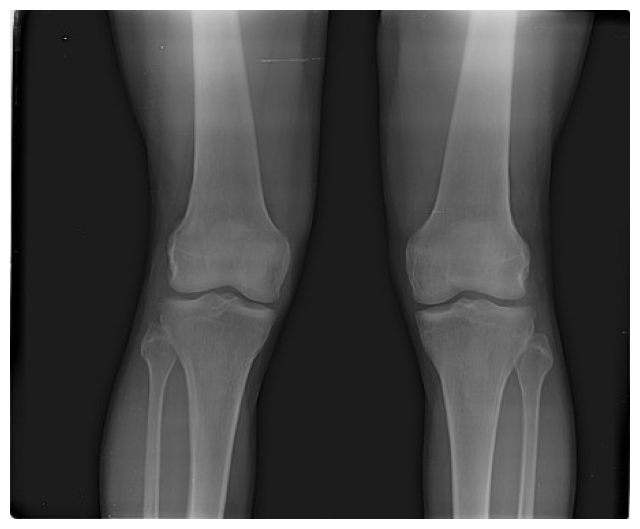

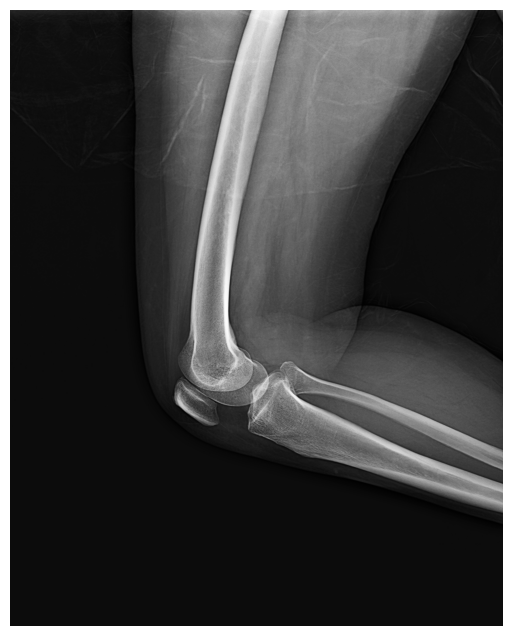

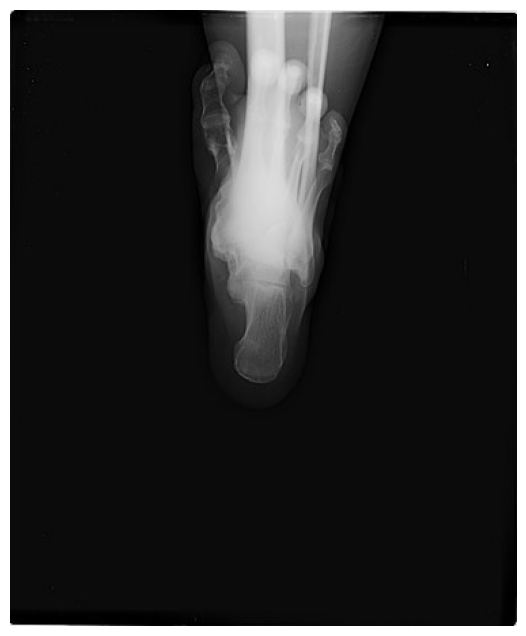

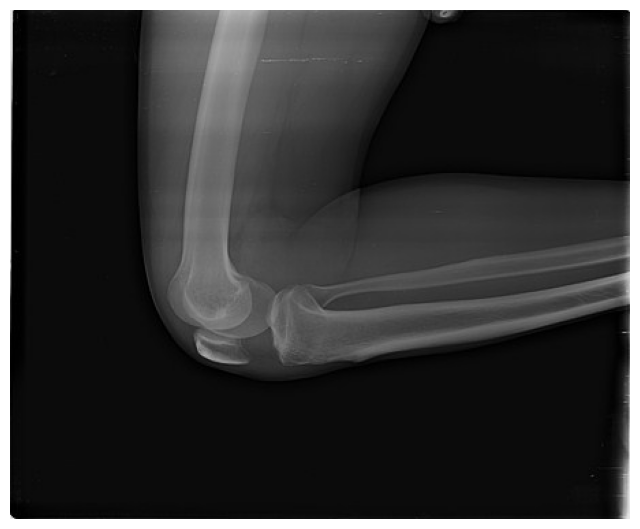

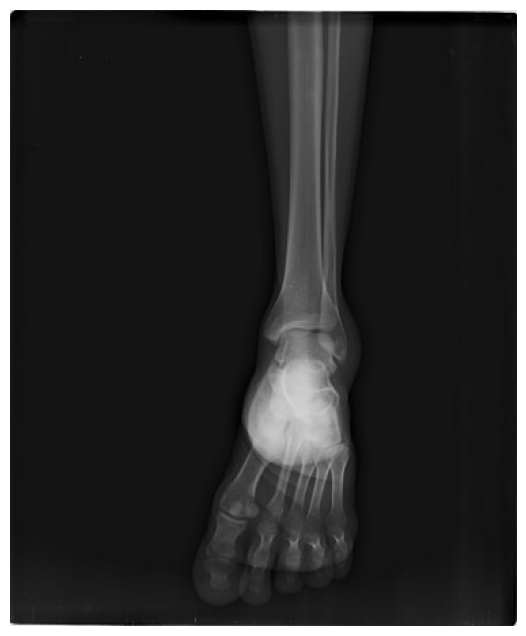

In [21]:
# Function to overlay bounding boxes on images
def draw_bounding_boxes(img_path, annotation_path, save_dir=None):
    # Loading the image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_height, img_width, _ = img.shape

    # Checking if annotation exists
    if not os.path.exists(annotation_path):
        warnings.warn(f"Annotation file {annotation_path} not found. Skipping.")
        return None

    # Reading YOLO annotations
    with open(annotation_path, 'r') as file:
        lines = file.readlines()

    for line in lines:

        # YOLO format: class_id, x_center, y_center, width, height (all relative)
        parts = line.strip().split()
        if len(parts) != 5:
            warnings.warn(f"Invalid annotation format in {annotation_path}. Skipping.")
            continue

        class_id, x_center, y_center, width, height = map(float, parts)

        # Converting relative coordinates to absolute pixel values
        x_center *= img_width
        y_center *= img_height
        width *= img_width
        height *= img_height

        # Calculating box corners
        x_min = int(x_center - width / 2)
        y_min = int(y_center - height / 2)
        x_max = int(x_center + width / 2)
        y_max = int(y_center + height / 2)

        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)

    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, os.path.basename(img_path))
        plt.imsave(save_path, img)

    plt.show()

for img_path, label in zip(data_dict_old["inputs"][:5], data_dict_old["labels"][:5]):

    img_name = os.path.splitext(os.path.basename(img_path))[0]
    annotation_path = os.path.join(annotations_dir, img_name + '.txt')

    draw_bounding_boxes(img_path, annotation_path)

# CNN Hyperparameter Tuning

In [22]:
import tensorflow.keras as keras
from tensorflow.keras.callbacks import EarlyStopping


In [23]:
pip install keras-tuner

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# CNN Baseline

In [42]:
def build_baseline_model():
  model = Sequential()

  model.add(Conv2D(filters=64, kernel_size=3, activation='relu', input_shape=(128, 128, 1)))
  model.add(BatchNormalization())

  model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
  model.add(BatchNormalization())

  model.add(GlobalAveragePooling2D())
  model.add(Dense(units=512, activation='softmax'))

  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  return model

baseline_model = build_baseline_model()

history = baseline_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

train_loss, train_acc = baseline_model.evaluate(X_train, y_train, verbose=2)
print('Train Accuracy:', train_acc)

val_loss, val_acc = baseline_model.evaluate(X_val, y_val, verbose=2)
print('Validation Accuracy:', val_acc)

Epoch 1/10
36/36 [==============================] - 6s 92ms/step - loss: 6.0235 - accuracy: 0.4568 - val_loss: 5.9625 - val_accuracy: 0.4634
Epoch 2/10
36/36 [==============================] - 2s 49ms/step - loss: 5.2410 - accuracy: 0.5580 - val_loss: 5.0592 - val_accuracy: 0.4634
Epoch 3/10
36/36 [==============================] - 2s 46ms/step - loss: 3.4054 - accuracy: 0.5719 - val_loss: 3.1261 - val_accuracy: 0.4634
Epoch 4/10
36/36 [==============================] - 2s 47ms/step - loss: 1.3076 - accuracy: 0.5789 - val_loss: 1.8251 - val_accuracy: 0.4634
Epoch 5/10
36/36 [==============================] - 2s 46ms/step - loss: 0.7543 - accuracy: 0.5920 - val_loss: 1.2472 - val_accuracy: 0.4634
Epoch 6/10
36/36 [==============================] - 2s 46ms/step - loss: 0.6918 - accuracy: 0.6269 - val_loss: 1.1723 - val_accuracy: 0.4634
Epoch 7/10
36/36 [==============================] - 2s 48ms/step - loss: 0.6734 - accuracy: 0.6120 - val_loss: 0.9507 - val_accuracy: 0.4669
Epoch 8/10
36

In [73]:
# Hyperparameter Tuning

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, GlobalAveragePooling2D, Dense
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.callbacks import EarlyStopping

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = np.array([np.expand_dims(img, axis=-1) if img.ndim == 2 else img for img in X_train])
X_val = np.array([np.expand_dims(img, axis=-1) if img.ndim == 2 else img for img in X_val])

X_train = np.array([tf.image.resize(img, (128, 128)) for img in X_train])
X_val = np.array([tf.image.resize(img, (128, 128)) for img in X_val])

X_train = X_train.astype("float32")
X_val = X_val.astype("float32")

print(X_train.shape, X_val.shape)

y_train = np.array(y_train)
y_val = np.array(y_val)

def build_hypermodel(hp):
    model = Sequential()

    model.add(Conv2D(filters=hp.Int('conv_1_filters', min_value=16, max_value=128, step=16),
                     kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
                     activation='relu',
                     input_shape=(128, 128, 1)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(filters=hp.Int('conv_2_filters', min_value=32, max_value=128, step=16),
                     kernel_size=hp.Choice('conv_2_kernel', values=[3, 5]),
                     activation='relu'))
    model.add(BatchNormalization())
    
    model.add(Conv2D(filters=hp.Int('conv_3_filters', min_value=64, max_value=128, step=32),
                     kernel_size=hp.Choice('conv_3_kernel', values=[3, 5]),
                     activation='relu'))
    model.add(BatchNormalization())

    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=hp.Int('dense_units', min_value=64, max_value=512, step=64), activation='softmax'))

    optimizer = hp.Choice('optimizer', values=['adam', 'sgd'])
    learning_rate = hp.Float('learning_rate', min_value=0.0001, max_value=0.1, sampling='log')
    if optimizer == 'adam':
        optimizer_instance = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        optimizer_instance = tf.keras.optimizers.SGD(learning_rate=learning_rate)

    model.compile(optimizer=optimizer_instance, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

tuner = RandomSearch(
    build_hypermodel,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='cnn_tuning_fixed17'
)

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

tuner.search(
    X_train, y_train,
    epochs=5,
    batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)


(1147, 128, 128, 1) (287, 128, 128, 1)
Reloading Tuner from my_dir/cnn_tuning_fixed17/tuner0.json


In [74]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

best_model = tuner.get_best_models(num_models=1)[0]

history = best_model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

Epoch 1/5
72/72 [==============================] - 5s 56ms/step - loss: 2.7434 - accuracy: 0.6024 - val_loss: 2.3505 - val_accuracy: 0.6167
Epoch 2/5
72/72 [==============================] - 4s 53ms/step - loss: 2.4748 - accuracy: 0.6094 - val_loss: 2.2700 - val_accuracy: 0.5052
Epoch 3/5
72/72 [==============================] - 4s 53ms/step - loss: 2.1701 - accuracy: 0.6155 - val_loss: 1.8584 - val_accuracy: 0.6167
Epoch 4/5
72/72 [==============================] - 4s 54ms/step - loss: 1.8526 - accuracy: 0.6373 - val_loss: 1.7692 - val_accuracy: 0.4983
Epoch 5/5
72/72 [==============================] - 4s 52ms/step - loss: 1.5906 - accuracy: 0.6303 - val_loss: 1.4335 - val_accuracy: 0.6307


In [75]:
train_loss, train_acc = best_model.evaluate(X_train, y_train, verbose=2)
val_loss, val_acc = best_model.evaluate(X_val, y_val, verbose=2)

print(f"Train accuracy: {train_acc}, Validation accuracy: {val_acc}")

36/36 - 1s - loss: 1.3481 - accuracy: 0.6548 - 913ms/epoch - 25ms/step
9/9 - 0s - loss: 1.4335 - accuracy: 0.6307 - 255ms/epoch - 28ms/step
Train accuracy: 0.6547515392303467, Validation accuracy: 0.6306620240211487


In [76]:
X_test = np.array([np.expand_dims(img, axis=-1) if img.ndim == 2 else img for img in X_test])
X_test = np.array([tf.image.resize(img, (128, 128)) for img in X_test])
X_test = X_test.astype("float32")
y_test = np.array(y_test)

test_loss, test_acc = best_model.evaluate(X_test, y_test)

print(f"Test accuracy: {test_acc}, Test loss: {test_loss}")

5/5 [==============================] - 0s 23ms/step - loss: 1.5177 - accuracy: 0.6111
Test accuracy: 0.6111111044883728, Test loss: 1.5176901817321777


In [77]:
best_hps = tuner.get_best_hyperparameters()[0]
print(best_hps.values)

{'conv_1_filters': 48, 'conv_1_kernel': 5, 'conv_2_filters': 112, 'conv_2_kernel': 5, 'conv_3_filters': 96, 'conv_3_kernel': 5, 'dense_units': 64, 'optimizer': 'sgd', 'learning_rate': 0.002826642869055423}


In [81]:
best_model = tuner.get_best_models(num_models=1)[0]
model_summary = best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 48)      1248      
                                                                 
 batch_normalization (Batch  (None, 124, 124, 48)      192       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 120, 112)     134512    
                                                                 
 batch_normalization_1 (Bat  (None, 120, 120, 112)     448       
 chNormalization)                                                
                                                                 
 conv2d_2 (Conv2D)           (None, 116, 116, 96)      268896    
                                                                 
 batch_normalization_2 (Bat  (None, 116, 116, 96)      3

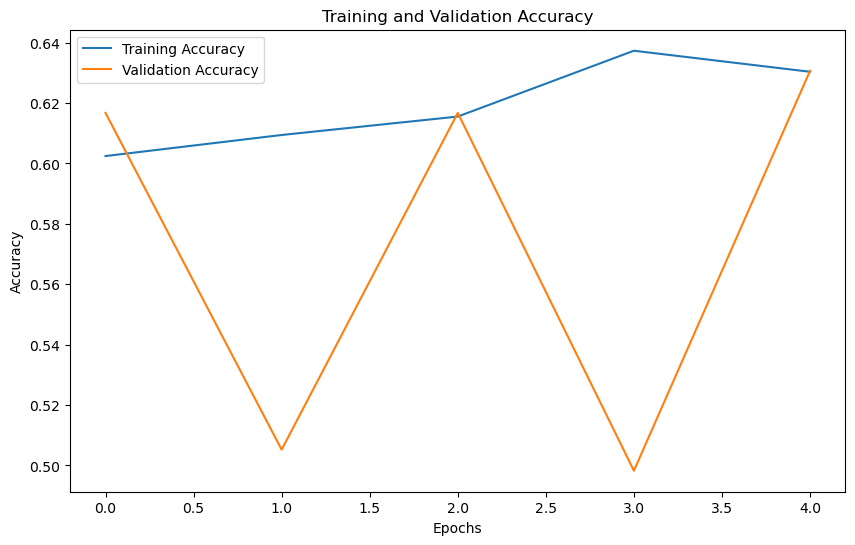

In [82]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


9/9 [==============================] - 0s 23ms/step


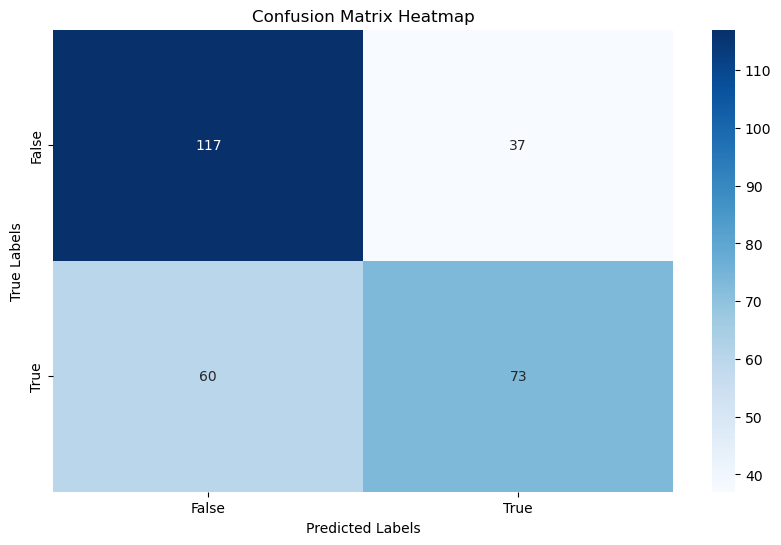

In [83]:
y_pred = best_model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_val, y_pred_classes)

plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_val), yticklabels=np.unique(y_val))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()


Hyperparameter Search Space:
* conv_1_filters: 16, 32, 48, 64, 80, 96, 112, 128
* conv_1_kernel: 3, 5
* conv_2_filters: 32, 48, 64, 80, 96, 112, 128
* conv_2_kernel: 3, 5
* conv_3_filters: 64, 96, 128
* conv_3_kernel: 3, 5
* dense_units: 64, 128, 192, 256, 320, 384, 448, 512
* optimizer: Adam, SGD
* learning_rate: 0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1

# Previous Code

In [ ]:
# import keras
# from kerastuner import HyperModel
# from kerastuner.tuners import RandomSearch


# class CNNHyperModel(HyperModel):
#     def build(self, hp):
#         model = keras.Sequential()
        
#         model.add(keras.layers.InputLayer(input_shape=(224, 224, 1)))
        
#         model.add(keras.layers.Conv2D(filters=hp.Int('conv_1_filters', min_value=16, max_value=128, step=16),
#                                       kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
#                                       activation='relu'))
#         model.add(keras.layers.BatchNormalization())
        
#         model.add(keras.layers.Conv2D(filters=hp.Int('conv_2_filters', min_value=32, max_value=128, step=16),
#                                       kernel_size=hp.Choice('conv_2_kernel', values=[3, 5]),
#                                       activation='relu'))
#         model.add(keras.layers.BatchNormalization())
        
#         model.add(keras.layers.Conv2D(filters=hp.Int('conv_3_filters', min_value=64, max_value=128, step=32),
#                                       kernel_size=hp.Choice('conv_3_kernel', values=[3, 5]),
#                                       activation='relu'))
#         model.add(keras.layers.BatchNormalization())
        
#         model.add(keras.layers.GlobalAveragePooling2D())
        
#         model.add(keras.layers.Dense(units=hp.Int('dense_units', min_value=64, max_value=512, step=64),
#                                      activation='softmax'))
        
#         optimizer = hp.Choice('optimizer', values=['adam', 'sgd'])
#         if optimizer == 'sgd':
#             model.compile(optimizer=keras.optimizers.SGD(learning_rate=hp.Float('learning_rate', min_value=0.0001, max_value=0.1, sampling='log')),
#                           loss='sparse_categorical_crossentropy',
#                           metrics=['accuracy'])
#         else:
#             model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=0.0001, max_value=0.1, sampling='log')),
#                           loss='sparse_categorical_crossentropy',
#                           metrics=['accuracy'])
        
#         return model

# tuner = RandomSearch(
#     CNNHyperModel(),
#     objective='val_accuracy',
#     max_trials=10,
#     executions_per_trial=1,
#     directory='my_dir',
#     project_name='cnn_tuning_3'
# )

# tuner.search(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_val, y_val))

# best_model = tuner.get_best_models(num_models=1)[0]
# best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
# print(f"Best hyperparameters: {best_hp.values}")


In [ ]:
import keras

cnn_model = keras.Sequential()

input_layer = keras.layers.InputLayer(input_shape=(224, 224, 1))
cnn_model.add(input_layer)

conv_1 = keras.layers.Conv2D(filters=32, kernel_size=5)  # Changed to 32 filters and 5x5 kernel
batchNorm_1 = keras.layers.BatchNormalization()
ReLU_1 = keras.layers.ReLU()
cnn_model.add(conv_1)
cnn_model.add(batchNorm_1)
cnn_model.add(ReLU_1)

conv_2 = keras.layers.Conv2D(filters=80, kernel_size=5)  # Changed to 80 filters and 5x5 kernel
batchNorm_2 = keras.layers.BatchNormalization()
ReLU_2 = keras.layers.ReLU()
cnn_model.add(conv_2)
cnn_model.add(batchNorm_2)
cnn_model.add(ReLU_2)

conv_3 = keras.layers.Conv2D(filters=96, kernel_size=3)  # Changed to 96 filters and 3x3 kernel
batchNorm_3 = keras.layers.BatchNormalization()
ReLU_3 = keras.layers.ReLU()
cnn_model.add(conv_3)
cnn_model.add(batchNorm_3)
cnn_model.add(ReLU_3)

pooling_layer = keras.layers.GlobalAveragePooling2D()
cnn_model.add(pooling_layer)

output_layer = keras.layers.Dense(units=256, activation='softmax')  # Changed to 256 units in the dense layer
cnn_model.add(output_layer)

cnn_model.summary()

cnn_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00983), # Adam optimizer with the best learning rate
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

history = cnn_model.fit(X_train, y_train, 
                        epochs=5,     
                        batch_size=64,   
                        validation_data=(X_val, y_val))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 32)      832       
                                                                 
 batch_normalization (Batch  (None, 220, 220, 32)      128       
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 220, 220, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 216, 216, 80)      64080     
                                                                 
 batch_normalization_1 (Bat  (None, 216, 216, 80)      320       
 chNormalization)                                                
                                                                 
 re_lu_1 (ReLU)              (None, 216, 216, 80)      0

2024-12-11 03:06:47.616215: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Epoch 1/5
10/85 [==>...........................] - ETA: 48:05 - loss: 2.5735 - accuracy: 0.4391

In [25]:
train_loss, train_accuracy = cnn_model.evaluate(X_train, y_train)
print("Evaluated performance on the training set.")
print('Loss:', str(train_loss) , 'Accuracy:', str(train_accuracy))

170/170 [==============================] - 14s 62ms/step - loss: 4.6777 - accuracy: 0.5000
Evaluated performance on the training set.
Loss: 4.677723407745361 Accuracy: 0.5


In [26]:
val_loss, val_accuracy = cnn_model.evaluate(X_val, y_val)
print("Evaluated performance on the validation set.")
print('Loss:', str(val_loss) , 'Accuracy:', str(val_accuracy))

13/13 [==============================] - 1s 56ms/step - loss: 1.9505 - accuracy: 0.8093
Evaluated performance on the validation set.
Loss: 1.950477957725525 Accuracy: 0.8092909455299377


In [27]:
test_loss, test_accuracy = cnn_model.evaluate(X_test, y_test)
print("Evaluated performance on the testing set.")
print('Loss:', str(test_loss) , 'Accuracy:', str(test_accuracy))

13/13 [==============================] - 1s 57ms/step - loss: 2.0105 - accuracy: 0.8020
Evaluated performance on the testing set.
Loss: 2.0104756355285645 Accuracy: 0.8019559979438782


# Previous Code 

In [ ]:
# cnn_model = keras.Sequential()

# # 2. Create the input layer and add it to the model object:
# input_layer = keras.layers.InputLayer(input_shape = (224, 224, 1))
# cnn_model.add(input_layer)

# # 3. Create the first convolutional layer and add it to the model object:
# conv_1 = keras.layers.Conv2D(filters=16, kernel_size=3)
# batchNorm_1 = keras.layers.BatchNormalization()
# ReLU_1 = keras.layers.ReLU()
# cnn_model.add(conv_1)
# cnn_model.add(batchNorm_1)
# cnn_model.add(ReLU_1)

# # 4. Create the second convolutional layer and add it to the model object:
# conv_2 = keras.layers.Conv2D(filters=32, kernel_size=3)
# batchNorm_2 = keras.layers.BatchNormalization()
# ReLU_2= keras.layers.ReLU()
# cnn_model.add(conv_2)
# cnn_model.add(batchNorm_2)
# cnn_model.add(ReLU_2)

# # 5. Create the third convolutional layer and add it to the model object:
# conv_3 = keras.layers.Conv2D(filters=64, kernel_size=3)
# batchNorm_3 = keras.layers.BatchNormalization()
# ReLU_3 = keras.layers.ReLU()
# cnn_model.add(conv_3)
# cnn_model.add(batchNorm_3)
# cnn_model.add(ReLU_3)

# # 7. Create the pooling layer and add it to the model object:
# pooling_layer = keras.layers.GlobalAveragePooling2D()
# cnn_model.add(pooling_layer)
# # 8. Create the output layer and add it to the model object:
# output_layer = keras.layers.Dense(units=10)
# cnn_model.add(output_layer)

# cnn_model.summary()

In [ ]:
sgd_optimizer = keras.optimizers.SGD(learning_rate = 0.1)
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
cnn_model.compile(optimizer=sgd_optimizer, loss=loss_fn, metrics=['accuracy'])

In [ ]:
train_loss, train_accuracy = cnn_model.evaluate(X_train, y_train)
print("Evaluated performance on the training set.")
print('Loss:', str(train_loss) , 'Accuracy:', str(train_accuracy))

170/170 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.7546 - loss: 0.5661
Evaluated performance on the training set.
Loss: 0.848770797252655 Accuracy: 0.5164388418197632


In [ ]:
val_loss, val_accuracy = cnn_model.evaluate(X_val, y_val)
print("Evaluated performance on the validation set.")
print('Loss:', str(val_loss) , 'Accuracy:', str(val_accuracy))

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 197ms/step - accuracy: 0.8228 - loss: 0.4651
Evaluated performance on the validation set.
Loss: 0.5037913918495178 Accuracy: 0.8092909455299377


In [ ]:
test_loss, test_accuracy = cnn_model.evaluate(X_test, y_test)
print("Evaluated performance on the testing set.")
print('Loss:', str(test_loss) , 'Accuracy:', str(test_accuracy))

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7873 - loss: 0.5289
Evaluated performance on the testing set.
Loss: 0.5255597233772278 Accuracy: 0.8019559979438782


In [ ]:
# Make predictions on the training set
logits_train = cnn_model.predict(X_train)
predictions_train = logits_train.argmax(axis = 1).astype('bool')

170/170 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step


In [ ]:
# Make predictions on the validation set
logits_val = cnn_model.predict(X_val)
predictions_val = logits_val.argmax(axis = 1).astype('bool')

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


In [ ]:
# Make predictions on the test set
logits_test = cnn_model.predict(X_test)
predictions_test = logits_test.argmax(axis = 1).astype('bool')

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


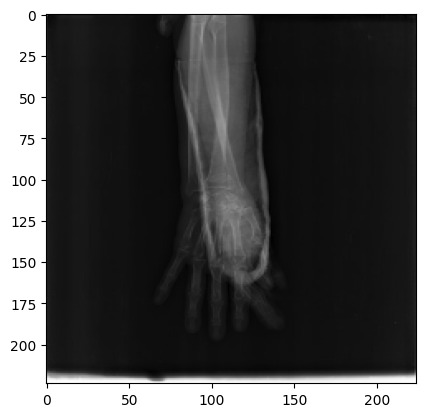

Ground truth: True
Prediction: True


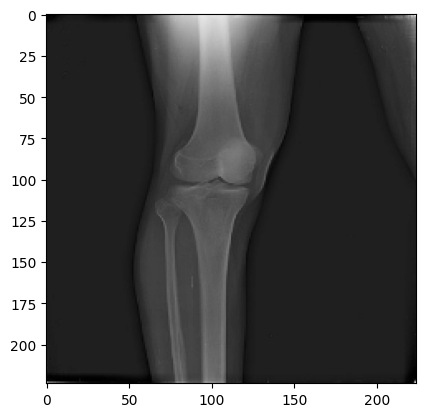

Ground truth: False
Prediction: False


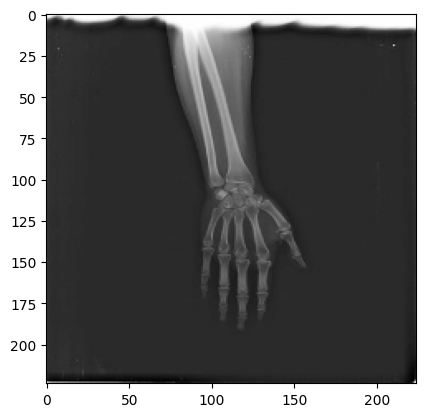

Ground truth: False
Prediction: False


In [ ]:
# print sample predictions for the training set
arr = random.sample(range(0, len(X_train)), 3)
for i in arr:
  plt.imshow(X_train[i], cmap='gray')
  plt.show()
  print("Ground truth:", y_train[i])
  print("Prediction:", predictions_train[i])

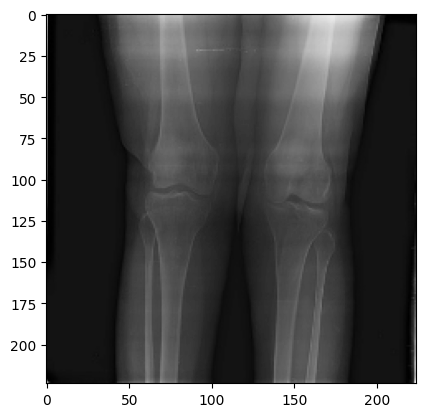

Ground truth: False
Prediction: False


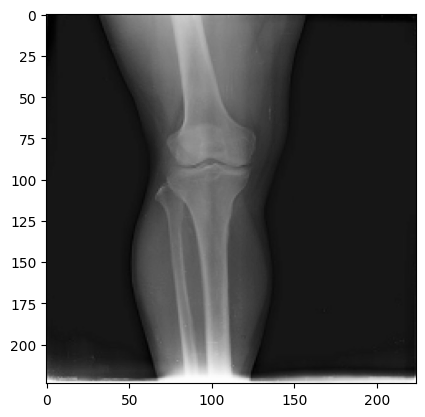

Ground truth: False
Prediction: False


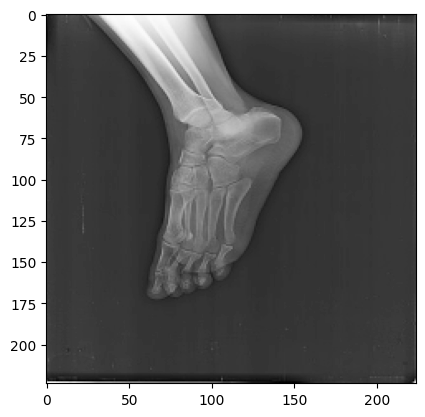

Ground truth: False
Prediction: False


In [ ]:
# print sample predictions for the validation set
arr = random.sample(range(0, len(X_val)), 3)
for i in arr:
  plt.imshow(X_val[i], cmap='gray')
  plt.show()
  print("Ground truth:", y_val[i])
  print("Prediction:", predictions_val[i])

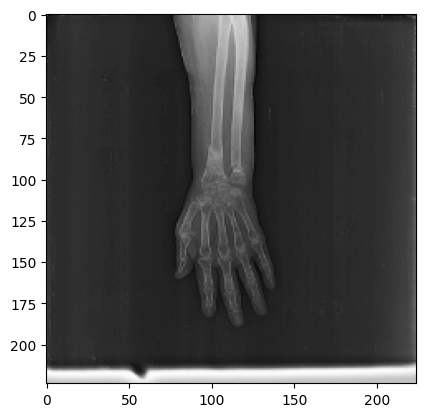

Ground truth: True
Prediction: False


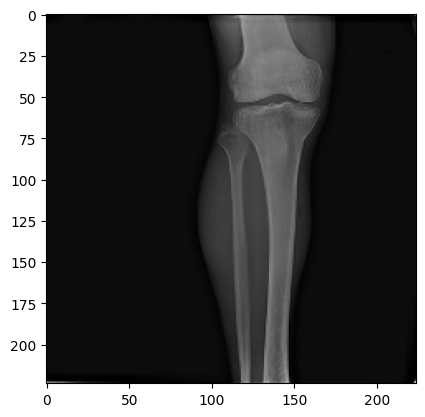

Ground truth: False
Prediction: False


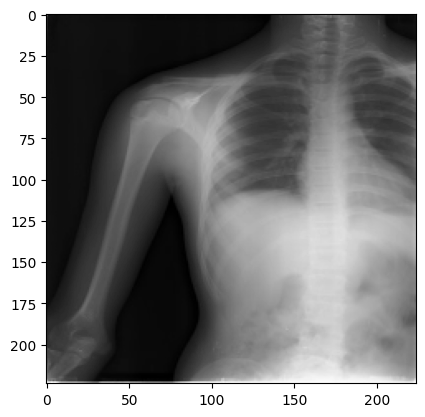

Ground truth: False
Prediction: False


In [ ]:
# print sample predictions for the testing set
arr = random.sample(range(0, len(X_test)), 3)
for i in arr:
  plt.imshow(X_test[i], cmap='gray')
  plt.show()
  print("Ground truth:", y_test[i])
  print("Prediction:", predictions_test[i])